In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm

In [2]:
theta = np.linspace(0, np.pi, 50)  
phi = np.linspace(0, 2 * np.pi, 50)  
theta, phi = np.meshgrid(theta, phi)


In [3]:

temperature_data = np.sin(2 * theta) * np.cos(3 * phi) + 0.5 * np.sin(5 * phi)


l, m = 5, 5
Y_lm = sph_harm(m, l, phi, theta).real  
approx_temp = np.abs(Y_lm) * np.max(temperature_data)  

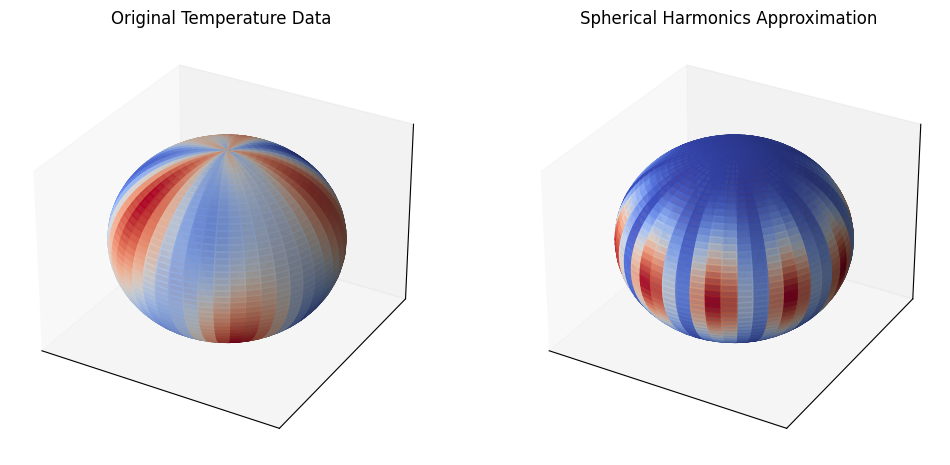

In [4]:
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)


fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, z, facecolors=plt.cm.coolwarm((temperature_data - temperature_data.min()) / 
                                                      (temperature_data.max() - temperature_data.min())),
                 rstride=1, cstride=1, alpha=0.9)
ax1.set_title("Original Temperature Data")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])


ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, z, facecolors=plt.cm.coolwarm((approx_temp - approx_temp.min()) /
                                                      (approx_temp.max() - approx_temp.min())),
                 rstride=1, cstride=1, alpha=0.9)
ax2.set_title("Spherical Harmonics Approximation")
ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])

plt.show()

In [5]:
from scipy.linalg import lstsq

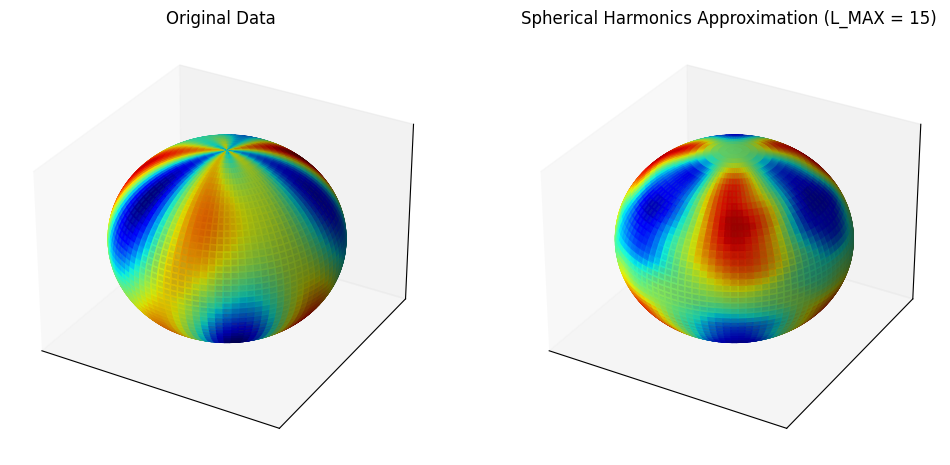

In [6]:

theta = np.linspace(0, np.pi, 50)  
phi = np.linspace(0, 2 * np.pi, 100)  
theta, phi = np.meshgrid(theta, phi)


real_data = np.sin(2 * theta) * np.cos(3 * phi) + 0.5 * np.sin(5 * phi)

x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)


L_MAX = 15  


Y_basis = []
for l in range(L_MAX + 1):
    for m in range(-l, l + 1):
        Y_basis.append(sph_harm(m, l, phi, theta).real)
Y_basis = np.array(Y_basis).reshape(len(Y_basis), -1).T  


coeffs, _, _, _ = lstsq(Y_basis, real_data.flatten())


approx_data = np.zeros_like(real_data.flatten())
for i, coef in enumerate(coeffs):
    approx_data += coef * Y_basis[:, i]
approx_data = approx_data.reshape(real_data.shape)  


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, z, facecolors=plt.cm.jet_r((real_data - real_data.min()) /
                                                      (real_data.max() - real_data.min())),
                 rstride=1, cstride=1, alpha=0.9)
ax1.set_title("Original Data")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])


ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, z, facecolors=plt.cm.jet_r((approx_data - approx_data.min()) /
                                                      (approx_data.max() - approx_data.min())),
                 rstride=1, cstride=1, alpha=0.9)
ax2.set_title("Spherical Harmonics Approximation (L_MAX = {})".format(L_MAX))
ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])

plt.show()

In [7]:
from pyhdf.SD import SD, SDC

In [8]:
def read_hdf(path, is_init):
    f = SD(path, SDC.READ)
    arr = f.select("Data-Set-2").get()
    dim0 = f.select("fakeDim0").get()
    dim1 = f.select("fakeDim1").get()
    if is_init:
        return arr, dim0, dim1
    dim2 = f.select("fakeDim2").get()
    return arr, dim0, dim1, dim2
    

In [54]:
data, ii, jj, kk = read_hdf('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/cr1751/kpo_mas_mas_std_0101/br002.hdf', False)

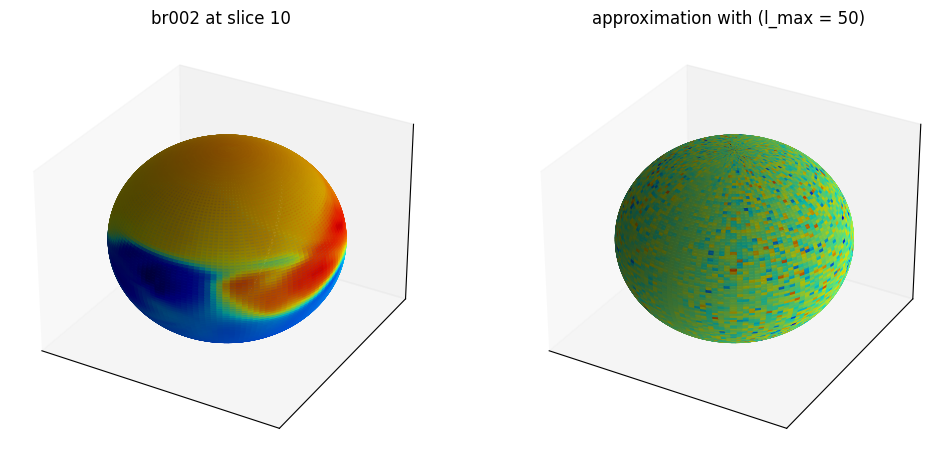

MAE: 0.26496056


In [63]:
theta, phi = np.meshgrid(ii, jj, indexing="ij")


real_data = data[:, :, 10]

x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)


L_MAX = 50


Y_basis = []
for l in range(L_MAX + 1):
    for m in range(-l, l + 1):
        Y_basis.append(sph_harm(m, l, phi, theta).real)
Y_basiss = np.array(Y_basis).reshape(len(Y_basis), -1).T


coeffs, _, _, _ = lstsq(Y_basiss, real_data.flatten())


approx_data = np.zeros_like(real_data.flatten())
for i, coef in enumerate(coeffs):
    approx_data += coef * Y_basiss[:, i]
approx_data = approx_data.reshape(real_data.shape)


min_ = min(real_data.min(), approx_data.min())
max_ = max(real_data.max(), approx_data.max())

yy = (real_data - real_data.min()) / (real_data.max() - real_data.min())
yhat = (approx_data - approx_data.min()) / (approx_data.max() - approx_data.min())


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(
    y,
    x,
    z,
    facecolors=plt.cm.jet_r(yy),
    rstride=1,
    cstride=1,
    alpha=0.9,
)
ax1.set_title("br002 at slice 10")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])


ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(
    y,
    x,
    z,
    facecolors=plt.cm.jet_r(yhat),
    rstride=1,
    cstride=1,
    alpha=0.9,
)
ax2.set_title("approximation with (l_max = {})".format(L_MAX))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

plt.show()

print("MAE:", np.mean(np.abs(yy - yhat)))